# K-Means Clustering
## Clustering temperatures into potentially 'seasons'

<br>

**READ**  -  I've created a python script to allow the user to click the button and then they can either have all of the underyling code shown, OR they can just look at the raw output (charts, plots, whatever).  
As you know, sometimes these notebooks contain a fair amount of code... and sometimes folks just want the _results_... here is an [example](https://nbviewer.jupyter.org/urls/gist.github.com/masnick/d6a1af14812c0c4b3314/raw/f7a5abfb6475e683a90b4ac3491d134ef604e460/test.ipynb)

Code defaults to NOT showing any code, so click the toggle button to view the show the underlying code...

In [1]:
# %load toggle.py
# allows code to be hidden, unhidden on jupyter notebook
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide All Notebook Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });</script><form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show All Notebook Code"></form>''')

<br>

In [2]:
import warnings  
warnings.filterwarnings('ignore')
import os
import dask 
import dask.dataframe as dd
from dask.distributed import Client, progress
import pandas as pd 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs
from plotly.offline import init_notebook_mode 
from plotly.offline import plot, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.io as pio
# sns.set_style("white")

In [3]:
%cd D:\CRITICAL_MAIN_DATAFILE__MILESTONE_II\AoT_Chicago.complete.2021-09-12    

D:\CRITICAL_MAIN_DATAFILE__MILESTONE_II\AoT_Chicago.complete.2021-09-12


In [4]:
df = pd.read_csv('use_for_UML.csv', index_col  = ['timestamp'])  # 1.8M rows

I will keep the seperate timestamp col T for my plots

In [5]:
df.head()
df.tail()

,sensor,value_hrf,T
timestamp,,,
2018-05-01 00:00:18,bmp180,30.2,2018-05-01 00:00:18
2018-05-01 00:00:44,bmp180,30.3,2018-05-01 00:00:44
2018-05-01 00:01:10,bmp180,30.4,2018-05-01 00:01:10
2018-05-01 00:01:35,bmp180,30.3,2018-05-01 00:01:35
2018-05-01 00:02:01,bmp180,30.4,2018-05-01 00:02:01


,sensor,value_hrf,T
timestamp,,,
2019-10-31 23:57:55,bmp180,2.5,2019-10-31 23:57:55
2019-10-31 23:58:20,bmp180,2.5,2019-10-31 23:58:20
2019-10-31 23:58:45,bmp180,2.5,2019-10-31 23:58:45
2019-10-31 23:59:10,bmp180,2.6,2019-10-31 23:59:10
2019-10-31 23:59:35,bmp180,2.6,2019-10-31 23:59:35


In [6]:
df.drop('sensor', axis=1, inplace=True)

In [7]:
df['T'] = df['T'].astype('datetime64[ns]')

In [8]:
df.dtypes

value_hrf           float64
T            datetime64[ns]
dtype: object

In [9]:
# # Using graph_objects
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import plotly
# import matplotlib.pyplot as plt
# from matplotlib import pyplot
# import plotly.graph_objs as go
# init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# fig = go.Figure(data=[go.Scatter(x=df.index,  y=df.value_hrf)])
# iplot(fig); 

#####  Split Data into over a year 

In [10]:
# tdf = df.loc['2018-09-01':'2018-10-01'].copy()
tdf = df.loc['2018-07-01':'2019-08-31'].copy()

In [11]:
del df # to be safe

In [12]:
len(tdf) # 1 439 432, 1.4M rows from single sensor

1439432

#####  Graphing data

In [13]:
# from sklearn.ensemble import IsolationForest
# clf = IsolationForest(n_estimators=100, 
#                     max_samples='auto', 
#                     contamination=float(.01), 
#                     max_features=1.0, 
#                     bootstrap=False, 
#                     n_jobs=-1, 
#                     random_state=42, 
#                     verbose=1)
# clf.fit(tdf[['value_hrf']])  # since 1D ! 
# # The predict function classifies the data as anomalies 
# # based on the results from decision function on crossing a threshold
# tdf['scores']=clf.decision_function(tdf[['value_hrf']])
# #tdf['anomaly']=clf.predict(tdf[['value_hrf']])
# #tdf.loc[tdf['anomaly'] == 1,'anomaly'] = 0
# #tdf.loc[tdf['anomaly'] == -1,'anomaly'] = 1
# ## classified as -1 is 'anomalous'
# #tdf.anomaly.value_counts()
# pred = clf.predict(tdf[['value_hrf']])
# tdf['anomaly']=pred
# outliers=tdf.loc[tdf['anomaly']==-1]
# outlier_index=list(outliers.index)
# #Find the number of anomalies and normal points here points classified -1 are anomalous
# print(tdf['anomaly'].value_counts())
# IsolationForest(contamination=0.01, n_jobs=-1, random_state=42, verbose=1)
#  1    86706
# -1      857
# Name: anomaly, dtype: int64
# print("Percentage of anomalies in data: {:.2f}".format((len(tdf.loc[tdf['anomaly']==-1])/len(tdf))*100))

In [14]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# %matplotlib inline
# # sns.set(style="darkgrid")
# fig, ax = plt.subplots(figsize=(15,10))
# sns.histplot(data=tdf, x="scores")
# plt.show(); 

This code will plot the entire dataset: 

In [15]:
# helpful:
#  import plotly.graph_objects as go
#  help(go.Figure.write_html)

In [16]:

## READ:

# very big output , keep file huge
# going to comment out the code, but all of this works

# --- uncomment this if you want to see the raw data ---

# fig = go.Figure(data=[go.Scatter(x=tdf.index,  
#                                  y=tdf.value_hrf)])
# fig = fig.update_layout(
#     title="Raw Temperature Data",
#     xaxis_title="timerange of recordings",
#     yaxis_title="Temperature in Celsius",
#     template = 'plotly_white', 
#     font=dict(size=12,color="RebeccaPurple"  ))

# # works:  
# # --- commenting out for now ---
# iplot(fig)

# --- if you want to export the plot to html for further study ---
# this code works for exporting:
# fig.write_html("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\iso_forest_base_data_plotted.html")

# Original plot screenshot shown below:


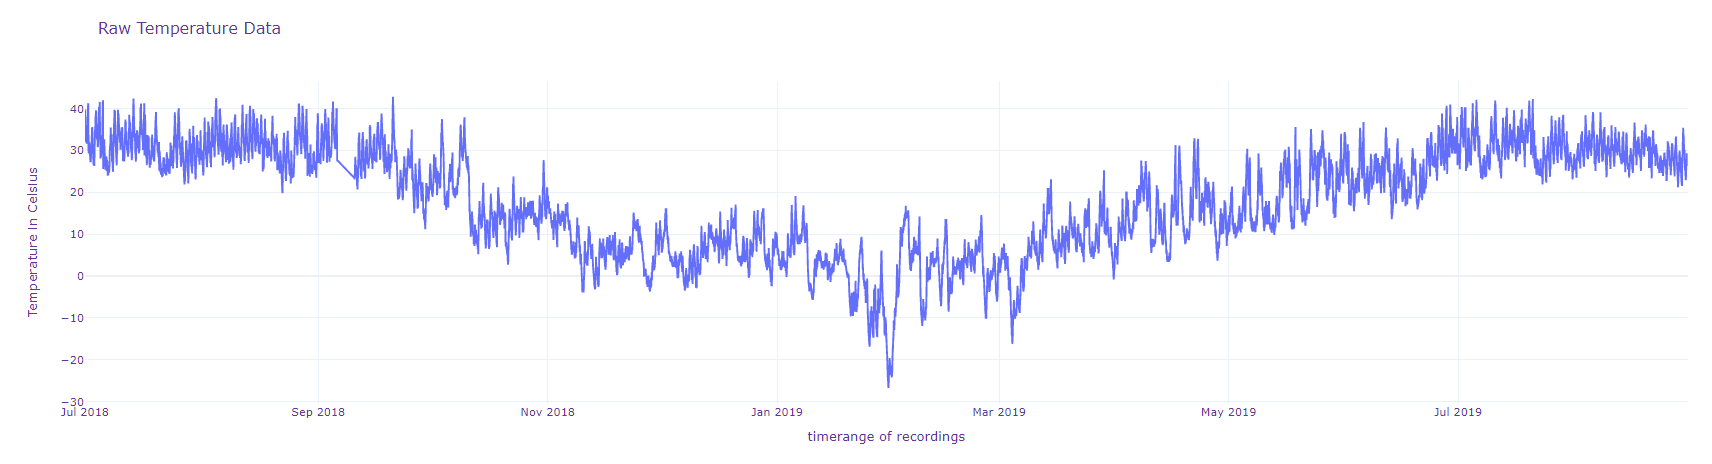

We might as well plot a boxplot for context as well:

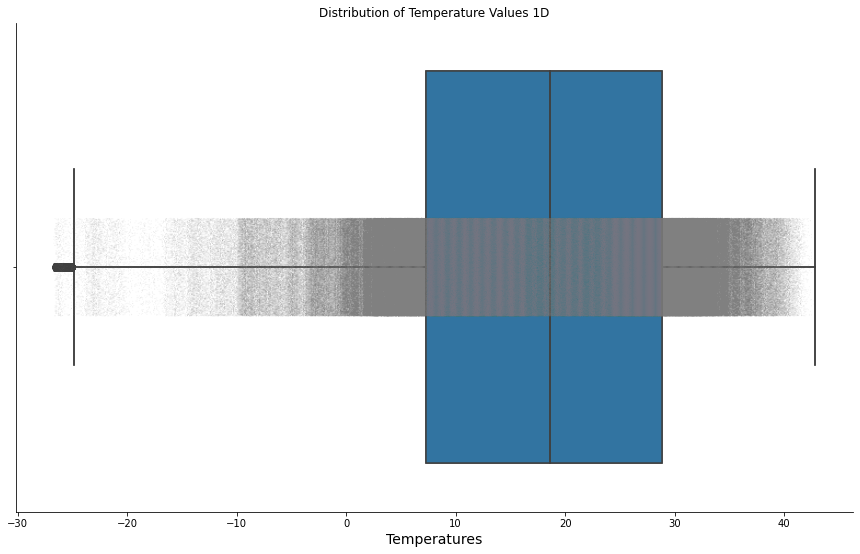

In [17]:
plt.figure(figsize=(15,9))
sns.boxplot(x=tdf.value_hrf)
boxplot = sns.boxplot(x=tdf.value_hrf, showfliers=True)
boxplot = sns.stripplot(x=tdf.value_hrf, 
                        marker="o",
                        size=1,
                        alpha=0.1, 
                        color="grey")
boxplot.axes.set_title("Distribution of Temperature Values 1D", fontsize=12)
boxplot.set_xlabel("Temperatures", fontsize=14)
boxplot.set_ylabel("", fontsize=14)
sns.despine()
plt.show(); 
# plt.savefig('D:\\GITHUB_Repos\\SensorAnalysis
# \\ENTER\\results\\histogram_isolation_forest.png', dpi=500)

In [18]:
# sns.swarmplot(tdf.value_hrf)

# Isolation Forest

Background:

Isolation forest is a machine learning algorithm for **anomaly detection**.
It's an unsupervised learning algorithm that identifies anomaly by isolating outliers in the data. Isolation Forest is based on the Decision Tree algorithm. It isolates the outliers by randomly selecting a feature from the given set of features (in my case, for this analysis there is a single feature 'temperature', and then randomly selecting a split value between the max and min values of that feature. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data.  Think of it as if an outlier is naturally easy to 'segment'. 

Starting: normally one would construct a profile of what's "normal", and then report anything that cannot be considered normal as anomalous. But isolation forest algorithm does not first define "normal" behavior, and does NOT calculate 'point-based' distances.

Isolation Forest instead works by isolating anomalies in the dataset. The Isolation Forest algorithm is based on the principle that anomalies are observations that are few and different, which should make them easier to identify. Isolation Forest uses an ensemble of Isolation Trees for the given data points to isolate anomalies. Presumably the anomalies need fewer random partitions to be isolated compared to "normal" points in the dataset, so the anomalies will be the points which have a smaller path length in the tree, path length being the number of edges traversed from the root node.

Later I will do multivariate data with this algorithm

#####  Working Code

In [19]:

from sklearn.ensemble import IsolationForest

# instantiate the IsolationForest class
# parameters to the Isolation Forest method: contamination, etc

clf = IsolationForest(n_estimators=100, 
       # the number of base estimators in the ensemble
       # refers to the number of base estimators or trees in the ensemble, 
       # i.e. the number of trees that will get built in the forest.
       
       max_samples='auto', 
       # number of samples to be drawn to train each base estimator
       # max_samples=min(256, n_samples)
        
       contamination=float(.015),
       # expected proportion of outliers in the data set
       # base assumption, critical to output

       max_features=1.0,
       # all the base estimators are not trained with all the 
       # features available in the dataset. It is the number 
       # of features to draw from the total features to train
       # each base estimator or tree.
                      
       bootstrap=False, 
       # If True, individual trees are fit on random subsets of the training 
       # data sampled with replacement. If False, sampling without 
       # replacement is performed.
                      
       n_jobs=-1, 
       # -1 means using all processors (number of job to run in parallel)
       
       random_state=42,
       verbose=1)


In [20]:
clf.fit(tdf[['value_hrf']])  
# make sure 2D-array, remember... 

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:    0.6s remaining:    7.1s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    0.6s finished


IsolationForest(contamination=0.015, n_jobs=-1, random_state=42, verbose=1)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

I like to actually understand this stuff:  

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

```
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:    0.6s remaining:    7.4s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    0.7s finished
```

tree building process...       

Isolation forests are an unsupervised extension of the popular random forest algorithm. The building blocks of isolation forests are isolation trees with a binary outcome (is/is not an outlier).

When an isolation forest is built, the algorithm splits each individual data point off from all other data points. The easier it is to isolate a single point in space from all other points, the more likely it is an outlier (because it’s far away from all other data points). If a data point is an in-lier, it will be closely surrounded by other data points, and will take more splits to isolate (1). See the graphic below as an illustration.

In [21]:
# add scores to the original dataframe 
tdf['scores']=clf.decision_function(tdf[['value_hrf']])

# Average anomaly score of X of the base classifiers
# The anomaly score of an input sample is computed as the 
# mean anomaly score of the trees in the forest.
# The measure of normality of an observation given a tree 
# is the depth of the leaf containing this observation, 
# which is equivalent to the number of splittings required
# to isolate this point. In case of several observations 
# n_left in the leaf, the average path length of a n_left
# samples isolation tree is added.

In [22]:
tdf['anomaly']=clf.predict(tdf[['value_hrf']])

#  This should be score of 1 or -1 
#  Here, we can see that both the anomalies are assigned an 
#  anomaly score of -1. Predict if a particular sample is an
#  outlier or not.  For each observation, tells whether or not 
#  (+1 or -1) it should be considered as an inlier 
#  according to the fitted model.

tdf.loc[tdf['anomaly'] == 1,'anomaly'] = 0

tdf.loc[tdf['anomaly'] == -1,'anomaly'] = 1

tdf.anomaly.value_counts()

0    1418024
1      21408
Name: anomaly, dtype: int64

In [23]:
clf.get_params()

{'bootstrap': False,
 'contamination': 0.015,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': -1,
 'random_state': 42,
 'verbose': 1,
 'warm_start': False}

In [24]:
# import seaborn as sns
# sns.displot(tdf, x="scores"); 
# # outliers 0 or below, but higher the score, more likely to be an inliner

#####  Important

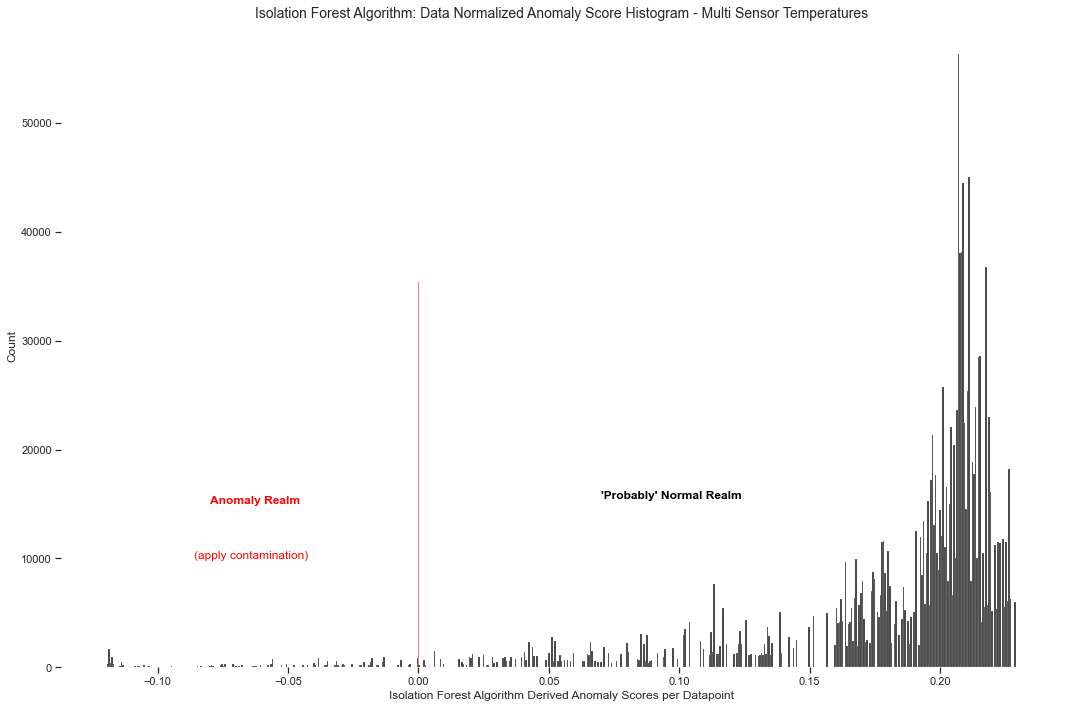

In [25]:
sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(data=tdf, 
             x="scores", 
             color='black',
             kde=False)

plt.axvline(x=0,ymin=0,ymax=0.6, linewidth=.5, color='red')
plt.title('Isolation Forest Algorithm: Data Normalized Anomaly Score Histogram - Multi Sensor Temperatures', 
         fontsize=14)
plt.xlabel("Isolation Forest Algorithm Derived Anomaly Scores per Datapoint")
plt.text(-.08, 15000, "Anomaly Realm", 
         horizontalalignment='left', 
         size='medium', 
         color='red', 
         weight='semibold'
        )
plt.text(-.086, 10000, "(apply contamination)", 
         horizontalalignment='left', 
         size='medium', 
         color='red', 
         )
plt.text(.07, 15500, "'Probably' Normal Realm", 
         horizontalalignment='left', 
         size='medium', 
         color='black', 
         weight='semibold')

# sns.despine()
sns.despine(bottom = True, left = True)
plt.tight_layout()                                                                    
plt.show();
# plt.savefig('D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\histogram_anomaly_scores_isolation_forest.png', dpi=800)

Inliers with positive scores are clubbed at right with positive scores. Points with negative scores are anomalies.

In [26]:
dates = tdf['T']

In [27]:
## DEFINED AND PLOTS THE ACTUAL DATAPOINTS 

from plotly.offline import init_notebook_mode, iplot
# Plot the actuals points (create plot)
original_data = go.Scatter(name='original_data',
                     x=dates,
                     y=tdf['value_hrf'],
                     xaxis='x1', yaxis='y1',
                     # mode = i think ok 
                     marker=dict(size=5,
                                 line=dict(width=1),
                                 color="gray"))

# uncomment this out if you want to see the raw data (plotted in grey):

# fig = go.Figure(data=[original_data])
# fig = fig.update_layout(title="", template="plotly_dark") 
# fig
# # iplot(fig)
# # this is just actuals, you could clean up to look prettier if you wanted !

# JUST SHOWING RAW DATA IF YOU WANTED... 

In [28]:
# PLOTS ONLY THE ANOMALIES 

bool_array = (abs(tdf['anomaly']) > 0)
actuals = tdf["value_hrf"][-len(bool_array):]
anomaly_pts = bool_array * actuals
anomaly_pts[anomaly_pts == 0] = np.nan
anomalies_red = go.Scatter(name="anomalies",
                               showlegend=True,
                               x=dates,
                               y=anomaly_pts,
                               mode='markers',
                               xaxis='x1',
                               yaxis='y1',
                               marker=dict(color="red",
                                           size=1,
                                           opacity=0.6,   
                                           line=dict(
                                              color="red",
                                              width=1)))
layout = dict(width=1000,
              height=865,
              autosize=False,
              title="demo", 
              margin=dict(t=75),
              showlegend=True)

# uncomment this out if you want to see via plotly ONLY the anomalies (which are in red):
#
# fig = go.Figure(data=[anomalies_red], layout=layout)
# fig = fig.update_layout(title="", template="plotly_dark")
# iplot(fig)


# JUST SHOWING ANOMALIES IF YOU WANTED... 

# Working Output ! 

In [29]:


# THIS WORKS BUT HAS HUGE HUGE OUTPUT:


# --- PLOTS ALL OF THE DATA AND IDENTIFIED ANOMALIES IN PLOTLY, FULLY INTERACTIVE ---
# uncomment out if you want to see it...


# fig = go.Figure(data=[original_data, anomalies_red], layout=layout)

# fig = fig.update_layout(title="Anomalies determined with Isolation Forest - Single Sensor - Chicago Region", 
#                        template="plotly_dark", 
#                        yaxis_title='Temperature in Celsius')
# LAUNCHES:
# iplot(fig)

# SAVING / EXPORTING: 
# works:  iplot(fig, image='svg', filename='D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\iso_forest_final_AD_plotted_2.svg')


# interesting:  this seems to export just fine but sometimes you have to do it twice:
# fig.write_html("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\isolation_forest_final_AD_plotted_superhighres.html")


# fig.write_image("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\isol_forest_final_AD_plotted.svg")
# plt.savefig('D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\histogram_anomaly_scores_isolation_forest.png', dpi=800)
# fig.write_html("isolation_forest_working_high_resolution.html")



> exported the html directly to github and plotting it [here](file:///D:/GITHUB_Repos/SensorAnalysis/ENTER/results/isolation_forest_final_AD_plotted_superhighres.html) (it has full html interactivity !)

---

I have to comment out the above code, it makes the notebook and html export very very large

IF you redownload this, just uncomment out, its nice, you can see interactive plotly plot of all of the anomalies, it looks like the below:
    
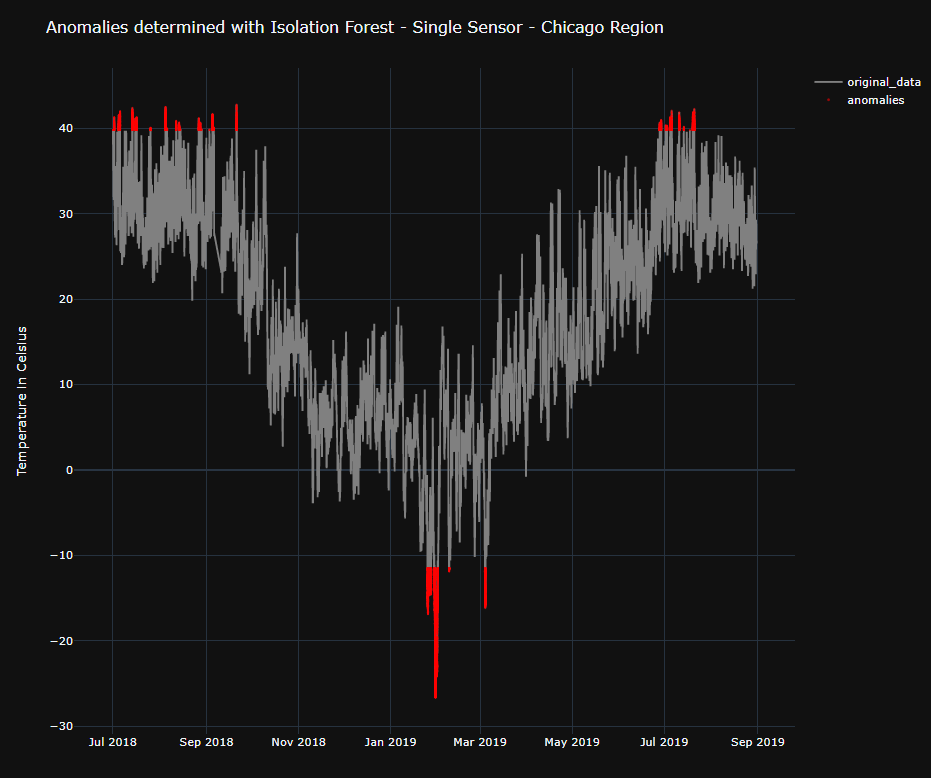

```OUTPUT:```

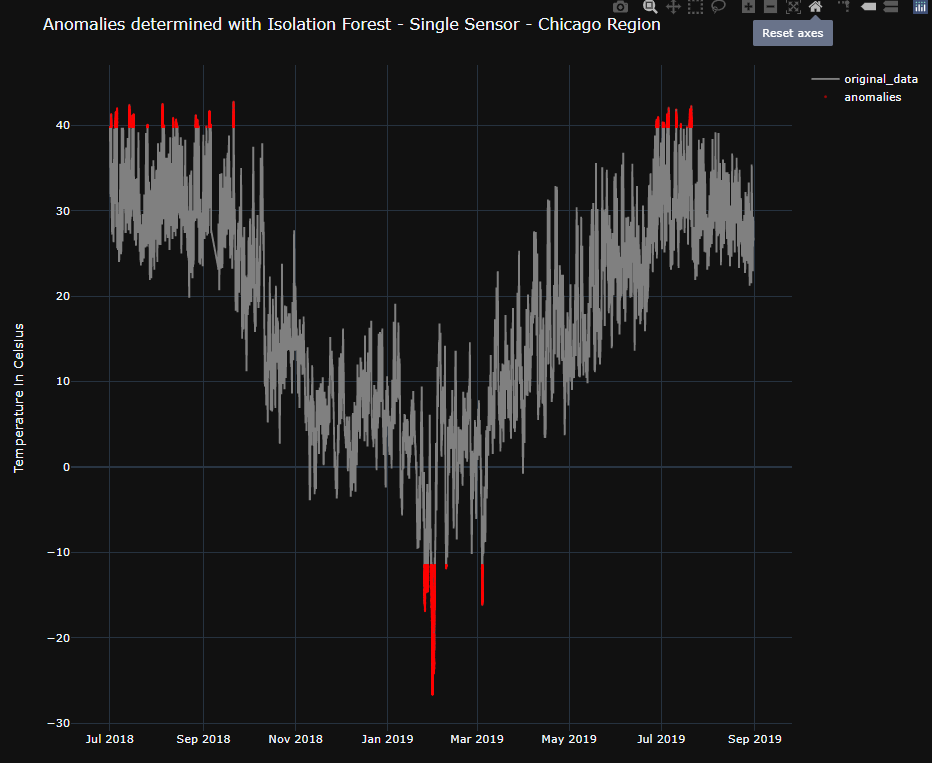

In [30]:
# when it is safe, you can kill this off ...

# from sklearn.ensemble import IsolationForest

# clf = IsolationForest(n_estimators=100, 
#                     max_samples='auto', 
#                     contamination=float(.01), 
#                     max_features=1.0, 
#                     bootstrap=False, 
#                     n_jobs=-1, 
#                     random_state=42, 
#                     verbose=1)

# clf.fit(tdf[['value_hrf']])  # since 1D ! 

# # The predict function classifies the data as anomalies 
# # based on the results from decision function on crossing a threshold

# tdf['score']=clf.decision_function(tdf[['value_hrf']])

# #tdf['anomaly']=clf.predict(tdf[['value_hrf']])
# #tdf.loc[tdf['anomaly'] == 1,'anomaly'] = 0
# #tdf.loc[tdf['anomaly'] == -1,'anomaly'] = 1
# ## classified as -1 is 'anomalous'
# #tdf.anomaly.value_counts()

# pred = clf.predict(tdf[['value_hrf']])
# tdf['anomaly']=pred

# outliers=tdf.loc[tdf['anomaly']==-1]

# outlier_index=list(outliers.index)

# #Find the number of anomalies and normal points here points classified -1 are anomalous

# # print(tdf['anomaly'].value_counts())

# # test_df['actuals']=metrics_df.iloc[:,i:i+1]

# #Get the indexes of outliers in order to compare the metrics with use case anomalies if required

# plot_anomaly(tdf, tdf.value_hrf)

**NOTE:** - IF you had the actual labels, which you don't, you could calculate the accuracy of the model by finding how many outliers the model found divided by how many outliers were present in the data.  Maybe someday we could identify that there were truly realms of anomalies like weather patterns, and do this...

Isolation forests are an unsupervised extension of the popular random forest algorithm. The building blocks of isolation forests are isolation trees with a binary outcome (is/is not an outlier).

When an isolation forest is built, the algorithm splits each individual data point off from all other data points. The easier it is to isolate a single point in space from all other points, the more likely it is an outlier (because it’s far away from all other data points). If a data point is an in-lier, it will be closely surrounded by other data points, and will take more splits to isolate (1). See the graphic below as an illustration.

### STOP AND BREATHE

<br><br><br>

<br><br><br>

# Appendix of Code References:

In [31]:
# # Using graph_objects
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import plotly
# import matplotlib.pyplot as plt
# from matplotlib import pyplot
# import plotly.graph_objs as go
# init_notebook_mode(connected=True)
# import plotly.graph_objs as go

In [32]:
# i think this is working...
# it is huge i think...
# import pandas as pd
# import plotly.express as px
# fig = px.scatter(df, x='T', 
#                 y='value_hrf',
#                 # color='output',
#                 hover_data=['T'])
# fig.update_layout(
#     autosize=False,
#     width=1000,
#     height=800,
#     margin=dict(
#         l=10,
#         r=10,
#         b=10,
#         t=10,
#         pad=4
#     ),
#     paper_bgcolor="white",
# )
# fig.update_traces(marker={'size': 1})    
# fig.show()

In [33]:
# import pandas as pd
# import plotly.express as px

# fig = px.scatter(df, x='T', 
#                 y='value_hrf',
#                 # color='output',
#                 hover_data=['T'])
# fig.update_layout(
#     autosize=False,
#     width=800,
#     height=500,
#     margin=dict(
#         l=10,
#         r=10,
#         b=10,
#         t=10,
#         pad=2
#     ),
#     paper_bgcolor="white",
# )
# fig.update_traces(marker={'size': 2})   
# fig.show()
# fig.write_html("high_resolution_2.html")

In [34]:
# import pandas as pd
# import plotly.express as px
# # fig = px.scatter(df, x='T', 
# #                 y='value_hrf',
# #                 # color='output',
# #                 hover_data=['T'])
# # fig.update_layout(
# #     autosize=False,
# #     width=800,
# #     height=500,
# #     margin=dict(
# #         l=10,
# #         r=10,
# #         b=10,
# #         t=10,
# #         pad=2
# #     ),
# #     paper_bgcolor="white",
# # )
# # fig.update_traces(marker={'size': 2})    
# # fig.show()
# import plotly.graph_objects as go
# fig = go.Figure(data=go.Scattergl(
#     x = df.T, 
#     y = df.value_hrf, 
#     mode='markers',
#     ))
# fig.show()

In [35]:

# fig.write_html("high_resolution_1.html")
